# Symbolic regression of LogS from chemical structural features.
Date: 2022/09/01 <br>
Authors: Takaki Katsushi, Tomoyuki Miyao

This tutorial explains how a LogS prediction SR model is built by the FGP-NLS library.
The logS data set was downloaded from [MoleculeNet](https://github.com/deepchem/deepchem)

In [13]:
import itertools
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import (max_error, mean_absolute_error,mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from figp import Symbolic_Reg

## Loading data set
The logS data set (and other useful benchmarking data sets) was already prepared by [deepchem](https://github.com/deepchem/deepchem). Here, just download the data from the github repository and save the file as `esol.csv`

In [14]:
url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'
df=pd.read_csv(url)

# df = pd.read_csv('data/esol.csv', sep=',', index_col=0)
print(f'Data set shape: {df.shape}')
df.head()
# does not work when column names contain spaces
df.columns = [s.replace(' ', '_').replace('-', '_') for s in df.columns]
df.head()

Data set shape: (1128, 10)


,Compound_ID,ESOL_predicted_log_solubility_in_mols_per_litre,Minimum_Degree,Molecular_Weight,Number_of_H_Bond_Donors,Number_of_Rings,Number_of_Rotatable_Bonds,Polar_Surface_Area,measured_log_solubility_in_mols_per_litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


## Splitting data set into training and test. 
Let X be the descriptor and y be a prediction target: logS.

In [15]:
yname = 'measured_log_solubility_in_mols_per_litre'
X = df.loc[:, 'Minimum_Degree':'Polar_Surface_Area']
y = df.loc[:, yname]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=600, random_state=0)

print(f'X train size: {X_train.shape}, X test size: {X_test.shape}')

X train size: (600, 6), X test size: (528, 6)


## Parameters for symbolic regression

population_size (int, optional): [description]. Defaults to 1000.  
The number of formulas to search per generation.  

generations (int, optional): [description]. Defaults to 200.  
The number of generations to repeat.  

tournament_size (int, optional): [description]. Defaults to 5.  
The number of candidates selected from the population. The best is selected from among them.  

num_elite_select (int, optional): [description]. Defaults to 1.  
The number of formulas that are always saved based on precision.  

max_depth (int, optional): [description]. Defaults to 4.  
Maximum depth of an individual. The higher the value, the higher the accuracy, but the calculation may take longer.  

function_set (list, optional): [description]. Defaults to ['add', 'sub', 'mul', 'div', 'ln', 'log', 'sqrt'].  
Operator to use in formulas.  

metric (str, optional): [description]. Defaults to 'mae'.  
Evaluation index.

p_crossover (float, optional): [description]. Defaults to 0.7.  
Probability of crossover. Crossover is an operation that exchanges parts of mathematical expressions.  

p_mutation (float, optional): [description]. Defaults to 0.2.  
Mutation Establishment. Mutation replaces part of the formula with a randomly generated formula.  

random_state (int, optional): [description]. Defaults to 0.  

const_range (tuple, optional): [description]. Defaults to (0, 1).  
A range of randomly generated constants. Optimized with this value as the initial value.  

x_domain ([type], optional): [description]. Defaults to None.  
The expected X range.  

y_domain ([type], optional): [description]. Defaults to None.  
The expected y range.  

results_dir (str, optional): [description]. Defaults to './results'.  
Specify where to save the results.  
Save with "Symbolic_Reg.save_all()".

## FGP-NLS model construction (three filters are on)
```
   function_filter = True
   variable_filter = True
   xydomain_filter = True
``` 


In [16]:
result_dir = './result_logS'
ydomain = y.min(), y.max() # for 
est = Symbolic_Reg( population_size=200,
                    generations=100,
                    tournament_size=5,
                    num_elite_select = 1,
                    max_depth=4,
                    function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'square', 'cube', 'ln', 'exp'),
                    metric='rmse', 
                    p_crossover=0.7, 
                    p_mutation=0.2, 
                    random_state=0,
                    x_domain=X,
                    y_domain=ydomain,
                    var_max_trial=5000,
                    function_filter = True, 
                    variable_filter = True, 
                    xydomain_filter = True,
                    constonly_filter= True,
                    domain_equal    = (True, True),
                    results_dir=result_dir)

# traininig
est.fit(X_train, y_train)

# save the training results
est.save_all()

  Gen  ! -- score-min -- ! -- score-med -- ! -- score-max -- ! -- score-std -- ! -- unique_rate -- ! -- nevals -- 
-------!-----------------!-----------------!-----------------!-----------------!-------------------!--------------
    0  !          1.63   !          3.58   !           inf   !          0.66   !            1.00   !   2.00e+02   
    1  !          1.62   !           inf   !           inf   !          0.71   !            0.73   !   1.52e+02   
    2  !          1.62   !           inf   !           inf   !          0.78   !            0.81   !   1.66e+02   
    3  !          1.49   !           inf   !           inf   !          0.67   !            0.69   !   1.47e+02   
    4  !          1.49   !           inf   !           inf   !          0.77   !            0.67   !   1.54e+02   
    5  !          1.49   !          3.58   !           inf   !          0.67   !            0.69   !   1.55e+02   
    6  !          1.49   !           inf   !           inf   !          0.56   !

## Prediction of the logS values for training and test data sets

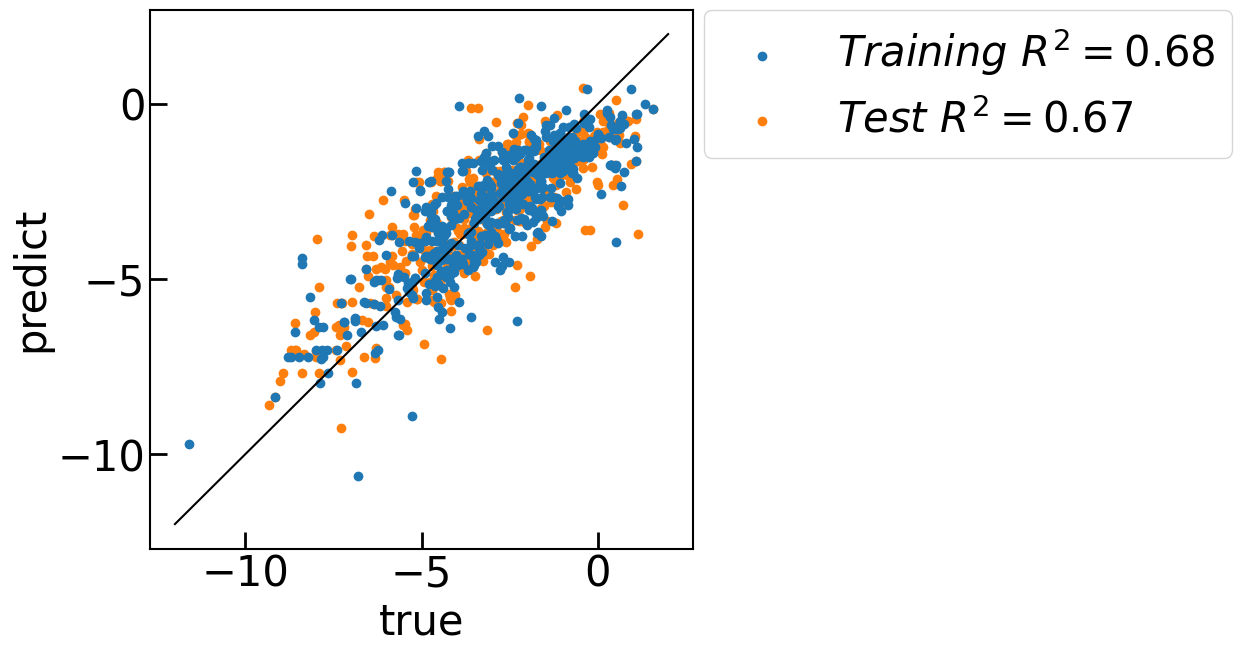

In [17]:
y_train_pred = est.predict(X_train)
y_test_pred  = est.predict(X_test)

# Evaluation
r2_train = r2_score(y_true=y_train, y_pred=y_train_pred)
r2_test  = r2_score(y_true=y_test,  y_pred=y_test_pred)

# YY plots 
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel('true'); ax.set_ylabel('predict')
ax.plot([-12, 2], [-12, 2], c='k')
ax.scatter(y_train, y_train_pred,  label=f'$Training\ R^2 = {r2_train:.2f}$')
ax.scatter(y_test, y_test_pred,    label=f'$Test\ R^2 = {r2_test:.2f}$', zorder=-1)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

## Looking at output files 
FGP-NLS models were saved in the directory specified in the `results_dir` argument when creating`Symbolic_Reg` instance.  

1. Files with the prefix of **001_GP_log** store RMSE values (fitness scores) during generation.  
2. Files with the prefix of **001_GP_node** show node profiles during generation.  
3. Files with the prefix of **002_best** contain the information of best formula.

In [18]:
result_files = glob.glob(f'{result_dir}/*')

print('Result file contents')
result_files

Result file contents


['./result_logS\\000_GP_log_txt.txt',
 './result_logS\\001_FilterGPSR_params.tsv',
 './result_logS\\001_GP_log.tsv',
 './result_logS\\001_GP_log_min_pl.png',
 './result_logS\\001_GP_log_pl.png',
 './result_logS\\001_GP_log_std_pl.png',
 './result_logS\\001_GP_log_unique_rate_pl.png',
 './result_logS\\001_GP_node_analysis.tsv',
 './result_logS\\001_GP_node_analysis_func_all_pl.png',
 './result_logS\\001_GP_node_analysis_func_all_select_pl.png',
 './result_logS\\001_GP_node_analysis_func_pl.png',
 './result_logS\\001_GP_node_analysis_func_select_pl.png',
 './result_logS\\001_GP_node_analysis_select.tsv',
 './result_logS\\001_GP_node_analysis_X_pl.png',
 './result_logS\\001_GP_node_analysis_X_select_pl.png',
 './result_logS\\002_best_expr4word.txt',
 './result_logS\\002_best_expr4word_3digits.txt',
 './result_logS\\002_best_expr4word_3digits_non_e.txt',
 './result_logS\\002_best_expr4word_non_e.txt',
 './result_logS\\002_best_model.tex',
 './result_logS\\002_best_model_expr.png']

### Showing RMSE values during generation.
Now, we can see that the how fitness values (RMSE) changed during evolution.

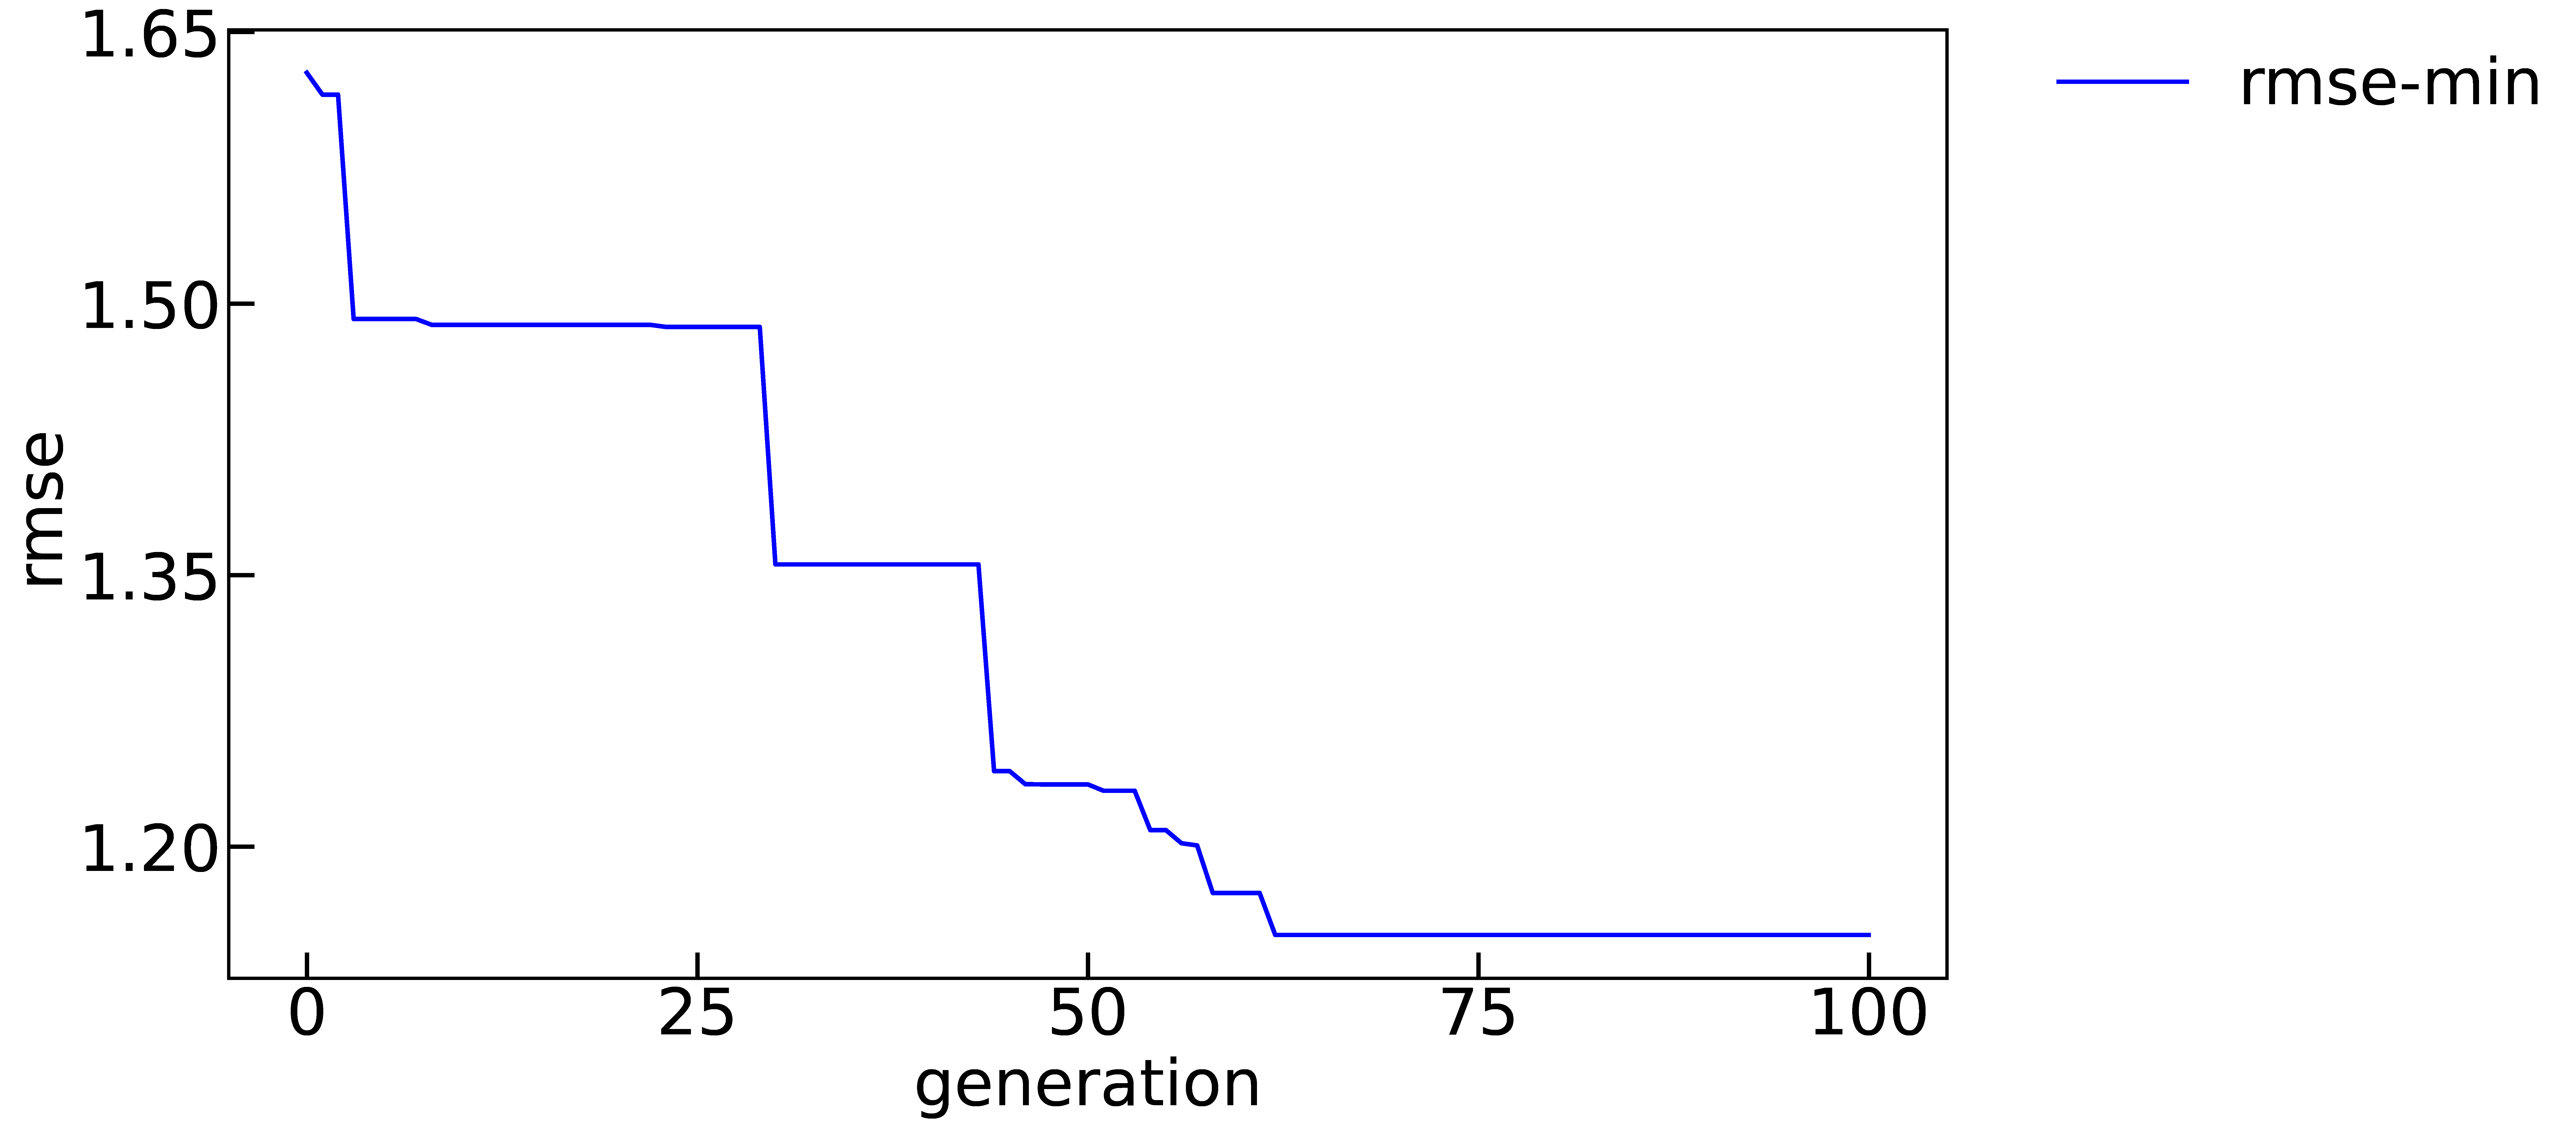

In [19]:
Image.open(f'{result_dir}/001_GP_log_min_pl.png').convert('RGB')

### Showing operator profiles during generation.
The below lines show the proportion of indivisuals containing specific operations.

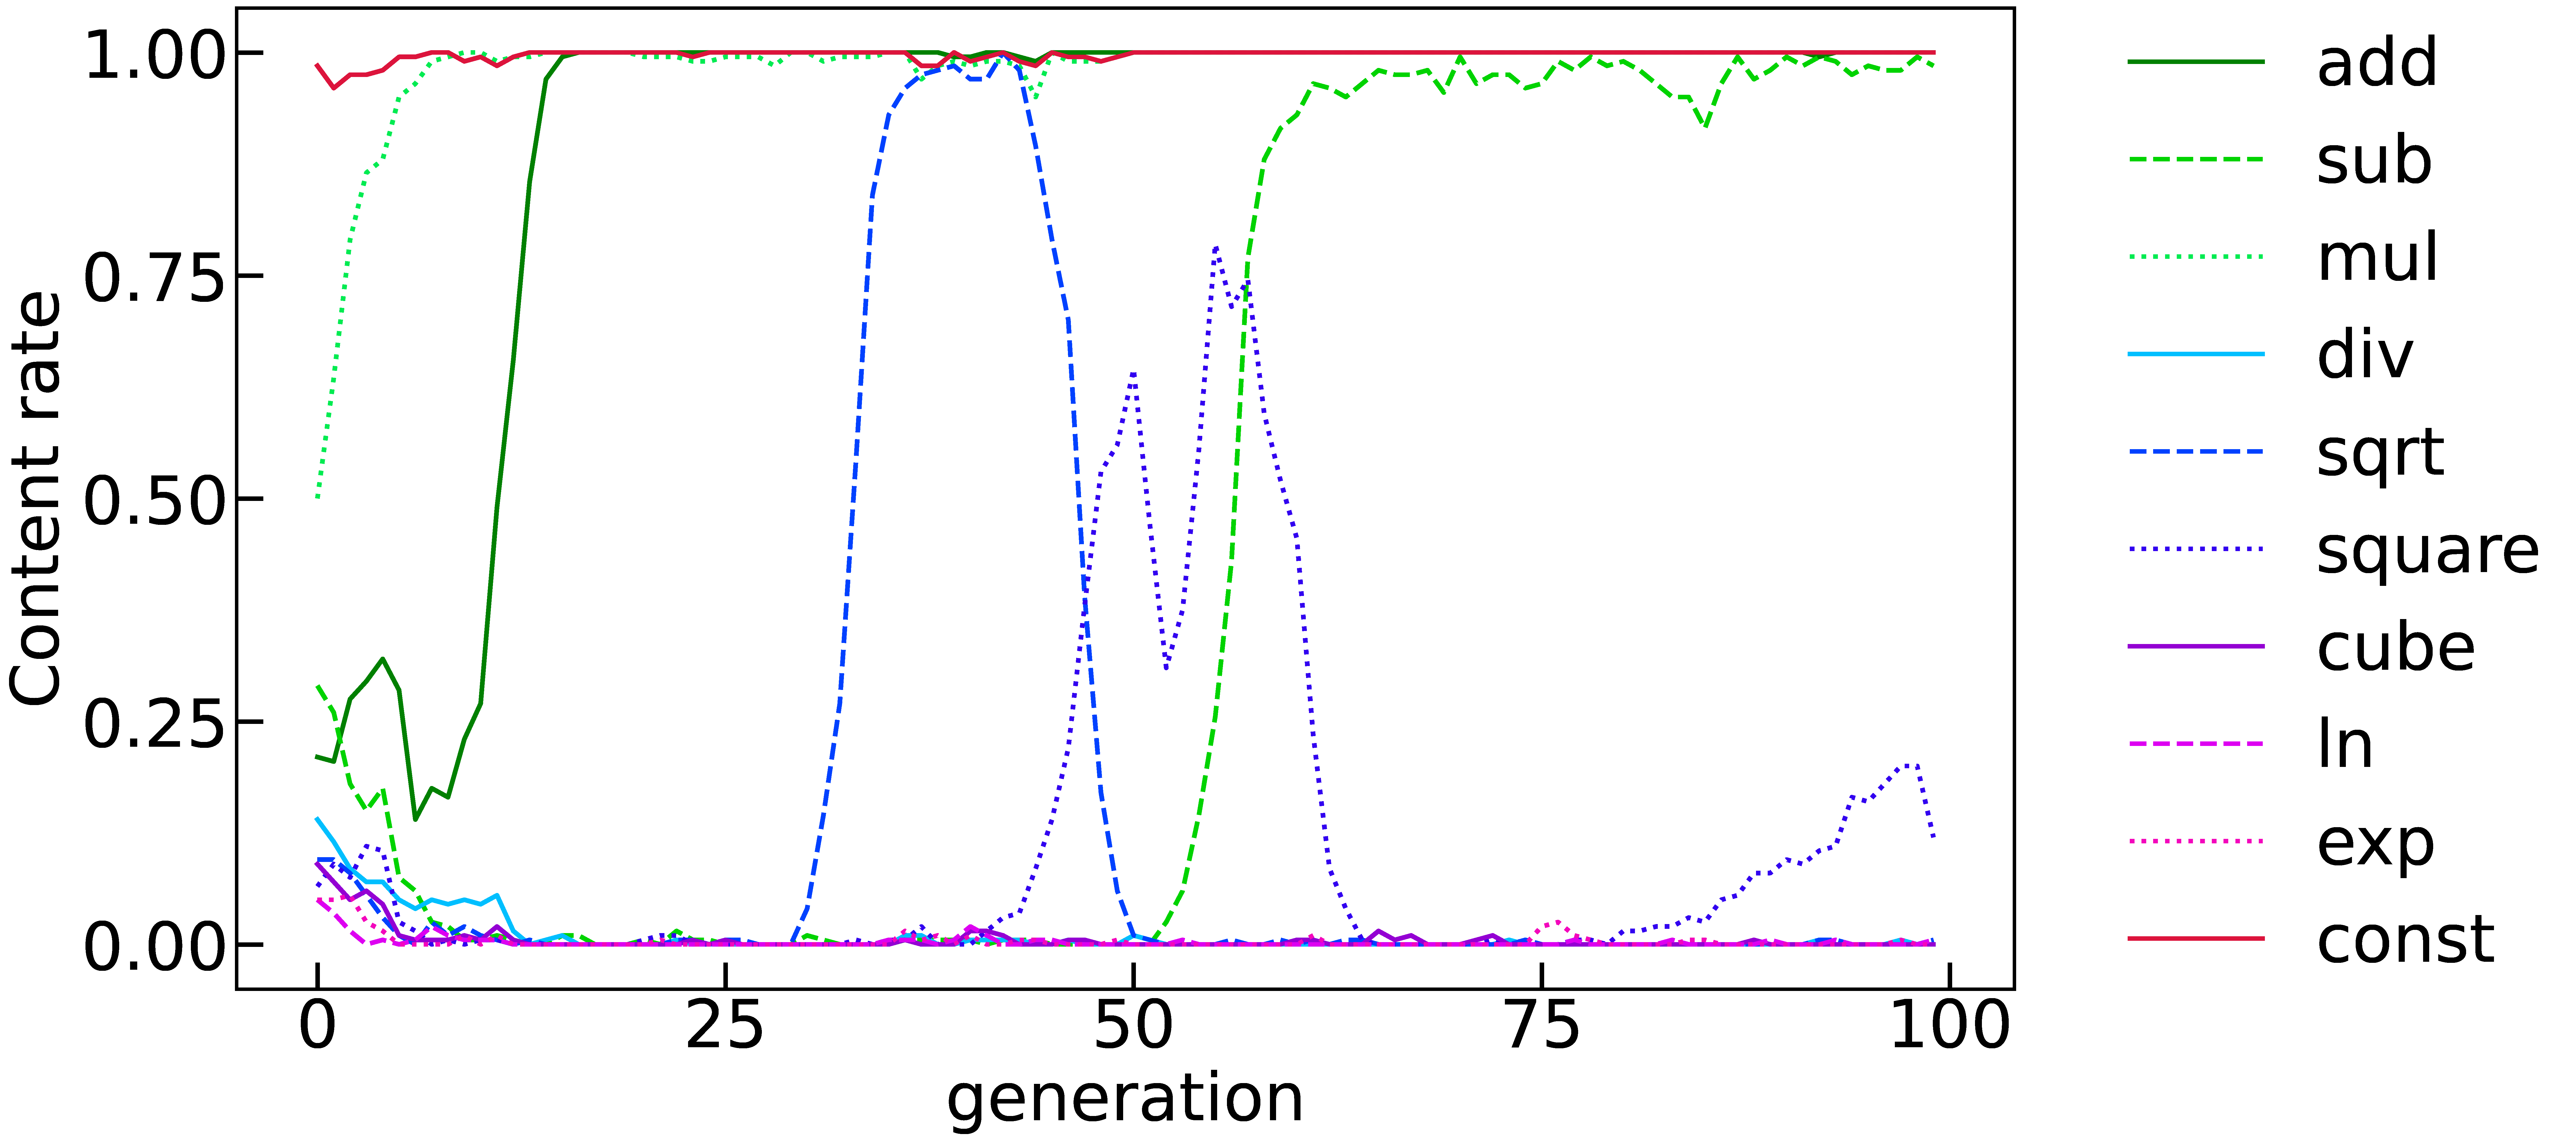

In [20]:
Image.open(f'{result_dir}/001_GP_node_analysis_func_select_pl.png').convert('RGB')

### Showing descriptor profiles during generation.
The below lines show the proportion of indivisuals containing specific descriptors.

In [21]:
Image.open(f'{result_dir}/001_GP_node_analysis_X_select_pl.png').convert('RGB')

### Showing best expression.
The selected formula is saved as an image.  
It may be different from the best stored formula for the last generation of "000_GP_log_txt.txt", but it has been simplified by the Sympy library.

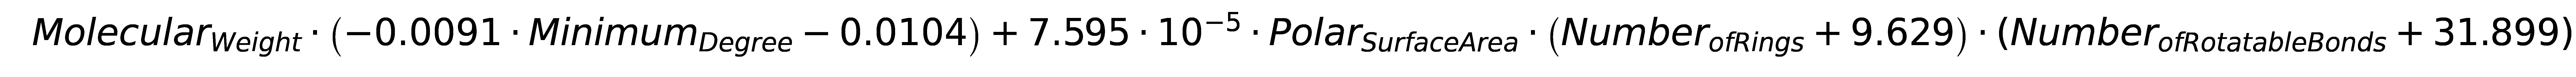

In [22]:
Image.open(f'{result_dir}/002_best_model_expr.png').convert('RGB')

### Log file contents
`After selection` is the formula selected from the previous generation.   
`After evolution` is a mathematical formula evolved by crossing and so on.   
`After const opt` is a constant optimized formula.  

example  
'After selection : formula  (score)

In [23]:
f = open(f'{result_dir}/000_GP_log_txt.txt')
lines = f.readlines()[:50]
f.close()
lines

[' 200 [ ind ] / 3888 [ trials ] (time : 0.070 min)\n',
 '\n',
 '=============== gen 0 ===============\n',
 'ind 0 : sqrt(div(Number_of_Rotatable_Bonds, Molecular_Weight))\n',
 'ind 1 : div(Molecular_Weight, 4432952972.787572)\n',
 'ind 2 : exp(div(-2858.8183429073306, Polar_Surface_Area))\n',
 'ind 3 : div(Number_of_H_Bond_Donors, -1.0732350467857141)\n',
 'ind 4 : sqrt(Minimum_Degree)\n',
 'ind 5 : sub(exp(-30.432572925935435), div(Minimum_Degree, -18430727.56056054))\n',
 'ind 6 : div(Minimum_Degree, 29303109.29810187)\n',
 'ind 7 : div(0.397983423606878, add(Molecular_Weight, Number_of_H_Bond_Donors))\n',
 'ind 8 : add(Minimum_Degree, ln(0.0181370523835336))\n',
 'ind 9 : mul(-0.014409544604695654, Molecular_Weight)\n',
 'ind 10 : div(sub(-0.1461288249639987, 0.7732086603244903), Molecular_Weight)\n',
 'ind 11 : mul(-0.5326208508019665, Number_of_Rings)\n',
 'ind 12 : add(-0.7184825156837291, Minimum_Degree)\n',
 'ind 13 : div(Number_of_Rotatable_Bonds, Molecular_Weight)\n',
 'ind 